In [15]:
import os
from os import listdir
from os.path import isfile, join
dir_files = [i for i in os.listdir(os.getcwd() + '/data') if os.path.isfile(join(os.getcwd() + '/data', i))]
dir_files

['2year.arff', '3year.arff', '5year.arff', '4year.arff', '1year.arff']

In [16]:
from scipy.io import arff
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [17]:
#combine all the files
data_dict = {}
full_df = pd.DataFrame()

records = 0

for f in dir_files:
    temp_data = arff.loadarff(os.getcwd() + '/data/' +f)
    temp_df = pd.DataFrame(temp_data[0])
    print(temp_df.shape)
    data_dict.update({f:temp_df})
    full_df = pd.concat([full_df, temp_df])
    records += temp_df.shape[0]

print(records)

(10173, 65)
(10503, 65)
(5910, 65)
(9792, 65)
(7027, 65)
43405


In [18]:
full_df.reset_index(inplace=True,drop=True)

In [19]:
missing_vals = full_df.isna().sum()
missing_vals = pd.DataFrame(missing_vals,columns=['missing'])
missing_vals = missing_vals.sort_values(by = ['missing'],ascending=False)
missing_vals.reset_index()

,index,missing
0,Attr37,18984
1,Attr21,5854
2,Attr27,2764
3,Attr60,2152
4,Attr45,2147
...,...,...
60,Attr10,8
61,Attr57,7
62,Attr59,7
63,Attr55,1


Text(0, 0.5, 'Attributes')

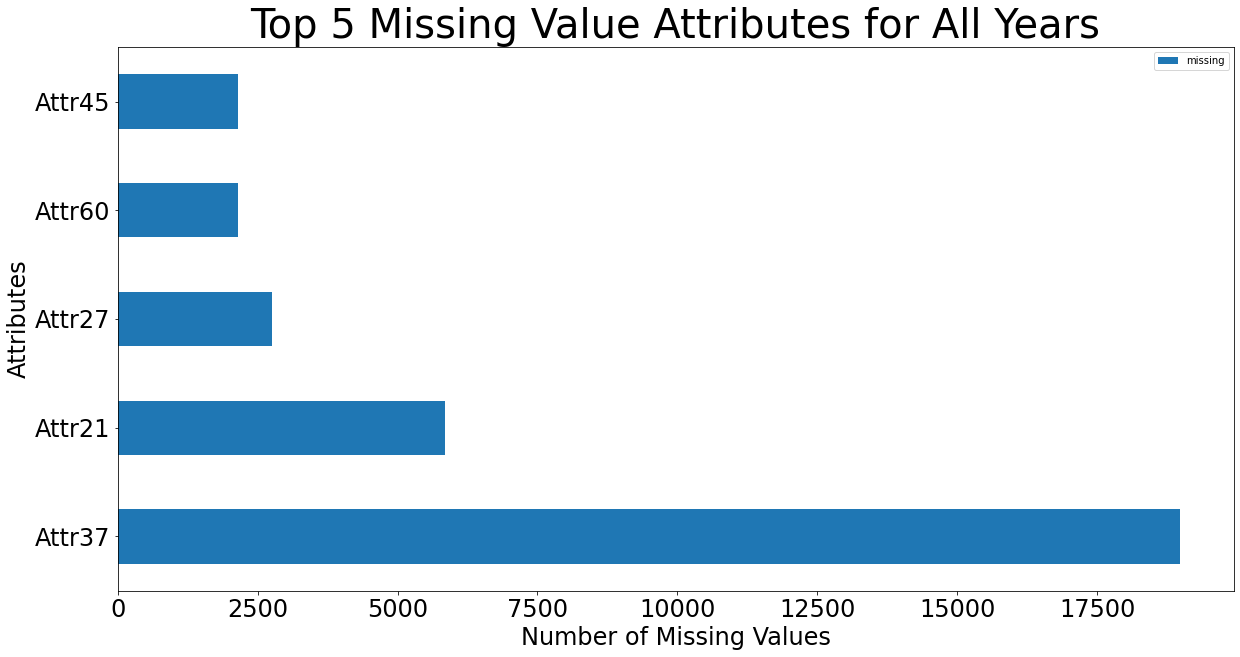

In [20]:
top_five_missing  = missing_vals.head(5)
ax = top_five_missing.plot.barh(title = 'Top 5 Missing Value Attributes for All Years'
,figsize = (20,10),fontsize=24)
ax.title.set_size(40)
ax.set_xlabel('Number of Missing Values',fontsize = 24)
ax.set_ylabel('Attributes',fontsize = 24)


In [21]:
full_df['class'].value_counts()

b'0'    41314
b'1'     2091
Name: class, dtype: int64

In [22]:
41314/43405

0.9518258265176823

In [23]:
classes = []
uniqueClass = full_df['class'].unique()
classes.append(uniqueClass[0])
classes.append(uniqueClass[1])
classes

[b'0', b'1']

In [24]:
class_dict = {}

for index, i in enumerate(classes):
    class_dict.update({i:index})

class_dict

{b'0': 0, b'1': 1}

In [25]:
full_df['class'] = full_df['class'].map(class_dict)

# Random Forest base model no cv to get feature importance

In [26]:
full_df['class'].value_counts()

0    41314
1     2091
Name: class, dtype: int64

In [27]:
full_df.isna().sum()

Attr1       8
Attr2       8
Attr3       8
Attr4     134
Attr5      89
         ... 
Attr61    102
Attr62    127
Attr63    134
Attr64    812
class       0
Length: 65, dtype: int64

In [28]:
# X = full_df.loc[:, full_df.columns != 'class'].values
# y = full_df['class'].values

# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 58)

In [29]:
X = full_df.drop("class", axis=1).copy()
y = full_df['class'].values

In [30]:
X.columns

Index(['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8',
       'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15',
       'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22',
       'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29',
       'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36',
       'Attr37', 'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43',
       'Attr44', 'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50',
       'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57',
       'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64'],
      dtype='object')

In [31]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
X_imp = imp_mean.fit_transform(X)




In [33]:
X_imp_df = pd.DataFrame(X_imp, columns=imp_mean.feature_names_in_)

In [38]:
X_imp_df.reset_index(inplace=True,drop=True)

In [39]:
from sklearn.preprocessing import StandardScaler
stdsclr = StandardScaler()
X_imp_scaled  = stdsclr.fit_transform(X_imp_df)

In [41]:
X_imp_scaled_df = pd.DataFrame(X_imp_scaled, columns=stdsclr.feature_names_in_)

In [18]:
rf_clf1 = RandomForestClassifier(random_state = 58)
rf_clf1.fit(X_train, y_train)
rf_clf1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 58,
 'verbose': 0,
 'warm_start': False}

In [19]:
y_hat_rf_test1 = rf_clf1.predict(X_test)
print("Confusion Matrix \n",confusion_matrix(y_test, y_hat_rf_test1))
print("\n Classification Report \n",classification_report(y_test, y_hat_rf_test1, digits=6))

Confusion Matrix 
 [[10301    30]
 [  358   163]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.966413  0.997096  0.981515     10331
           1   0.844560  0.312860  0.456583       521

    accuracy                       0.964246     10852
   macro avg   0.905486  0.654978  0.719049     10852
weighted avg   0.960563  0.964246  0.956313     10852



# Feature Importance

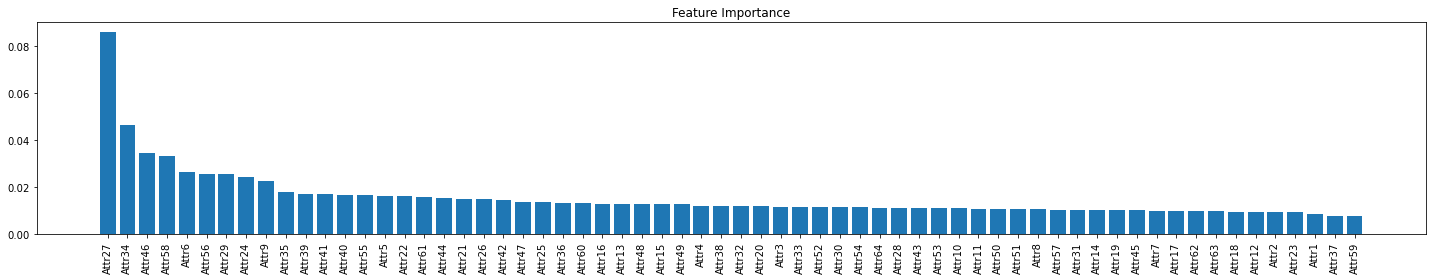

In [20]:
feature_importances = rf_clf1.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(20,4))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Random Forest Gridsearch


In [43]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
cv_grid = StratifiedKFold(n_splits=10,random_state=58, shuffle=True)

In [75]:
from sklearn.metrics import make_scorer, log_loss
logloss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [86]:
rf_clf2 = RandomForestClassifier(random_state=58)
param_grid = { 
    'n_estimators': [35,40,45],
    'max_features': ['auto'],
    'max_depth' : [20],
    'class_weight' : [None]
}
CV_rfc = GridSearchCV(estimator=rf_clf2, param_grid=param_grid, cv=cv_grid, n_jobs=2,scoring=logloss_scorer)
CV_rfc.fit(X_imp_scaled, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=58, shuffle=True),
             estimator=RandomForestClassifier(random_state=58), n_jobs=2,
             param_grid={'class_weight': [None], 'max_depth': [20],
                         'max_features': ['auto'],
                         'n_estimators': [35, 40, 45]},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

In [87]:
best_model = CV_rfc.best_params_
CV_rfc.best_params_

{'class_weight': None,
 'max_depth': 20,
 'max_features': 'auto',
 'n_estimators': 45}

In [88]:
CV_rfc.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=45, random_state=58)

In [89]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(CV_rfc.best_estimator_, X_imp_scaled, y, cv=cv_grid, n_jobs=2)

In [90]:
conf_mat = confusion_matrix(y, y_pred)
cl_report = classification_report(y, y_pred, digits=6)

In [91]:
conf_mat

array([[41202,   112],
       [ 1355,   736]])

In [92]:
print("\n Classification Report \n",cl_report)


 Classification Report 
               precision    recall  f1-score   support

           0   0.968160  0.997289  0.982509     41314
           1   0.867925  0.351985  0.500851      2091

    accuracy                       0.966202     43405
   macro avg   0.918042  0.674637  0.741680     43405
weighted avg   0.963332  0.966202  0.959305     43405



# XGBoost

In [94]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
estimator = XGBClassifier(
    nthread=4,
    seed=42,
    use_label_encoder = False,
    eval_metric='logloss'
)
parameters = {
   'max_depth': [15],
    'n_estimators': [60],
    'learning_rate': [0.05],
    
    
}
fit_params = {
'eval_set': [(X_imp_scaled,y)]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 2,
    cv = cv_grid,
    verbose=True,
    
)
grid_search.fit(X_imp_scaled, y, **fit_params, early_stopping_rounds = 50)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[0]	validation_0-logloss:0.64836
[0]	validation_0-logloss:0.64840
[1]	validation_0-logloss:0.60789
[1]	validation_0-logloss:0.60780
[2]	validation_0-logloss:0.57085
[2]	validation_0-logloss:0.57089
[3]	validation_0-logloss:0.53699
[3]	validation_0-logloss:0.53692
[4]	validation_0-logloss:0.50606
[4]	validation_0-logloss:0.50586
[5]	validation_0-logloss:0.47741
[5]	validation_0-logloss:0.47731
[6]	validation_0-logloss:0.45116
[6]	validation_0-logloss:0.45089
[7]	validation_0-logloss:0.42679
[7]	validation_0-logloss:0.42654
[8]	validation_0-logloss:0.40411
[8]	validation_0-logloss:0.40369
[9]	validation_0-logloss:0.38301
[9]	validation_0-logloss:0.38265
[10]	validation_0-logloss:0.36327
[10]	validation_0-logloss:0.36301
[11]	validation_0-logloss:0.34492
[11]	validation_0-logloss:0.34476
[12]	validation_0-logloss:0.32776
[12]	validation_0-logloss:0.32773
[13]	validation_0-logloss:0.31174
[13]	validation_0-logloss:0.31160
[14]	va

[1]	validation_0-logloss:0.60830
[2]	validation_0-logloss:0.57122
[2]	validation_0-logloss:0.57159
[3]	validation_0-logloss:0.53763
[3]	validation_0-logloss:0.53770
[4]	validation_0-logloss:0.50653
[4]	validation_0-logloss:0.50668
[5]	validation_0-logloss:0.47812
[5]	validation_0-logloss:0.47805
[6]	validation_0-logloss:0.45161
[6]	validation_0-logloss:0.45164
[7]	validation_0-logloss:0.42689
[7]	validation_0-logloss:0.42721
[8]	validation_0-logloss:0.40435
[8]	validation_0-logloss:0.40456
[9]	validation_0-logloss:0.38298
[9]	validation_0-logloss:0.38350
[10]	validation_0-logloss:0.36312
[10]	validation_0-logloss:0.36384
[11]	validation_0-logloss:0.34477
[11]	validation_0-logloss:0.34543
[12]	validation_0-logloss:0.32748
[12]	validation_0-logloss:0.32819
[13]	validation_0-logloss:0.31129
[13]	validation_0-logloss:0.31207
[14]	validation_0-logloss:0.29636
[14]	validation_0-logloss:0.29690
[15]	validation_0-logloss:0.28214
[15]	validation_0-logloss:0.28284
[16]	validation_0-logloss:0.268

[4]	validation_0-logloss:0.50654
[4]	validation_0-logloss:0.50671
[5]	validation_0-logloss:0.47788
[5]	validation_0-logloss:0.47828
[6]	validation_0-logloss:0.45157
[6]	validation_0-logloss:0.45200
[7]	validation_0-logloss:0.42704
[7]	validation_0-logloss:0.42758
[8]	validation_0-logloss:0.40427
[8]	validation_0-logloss:0.40488
[9]	validation_0-logloss:0.38316
[9]	validation_0-logloss:0.38378
[10]	validation_0-logloss:0.36374
[10]	validation_0-logloss:0.36419
[11]	validation_0-logloss:0.34540
[11]	validation_0-logloss:0.34576
[12]	validation_0-logloss:0.32820
[12]	validation_0-logloss:0.32865
[13]	validation_0-logloss:0.31221
[13]	validation_0-logloss:0.31253
[14]	validation_0-logloss:0.29708
[14]	validation_0-logloss:0.29747
[15]	validation_0-logloss:0.28279
[15]	validation_0-logloss:0.28329
[16]	validation_0-logloss:0.26951
[16]	validation_0-logloss:0.27006
[17]	validation_0-logloss:0.25703
[17]	validation_0-logloss:0.25758
[18]	validation_0-logloss:0.24587
[18]	validation_0-logloss:

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=58, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=No...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                 

In [95]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=60, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False, ...)

In [96]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred_xgb = cross_val_predict(grid_search.best_estimator_, X_imp_scaled, y, cv=cv_grid, n_jobs=2)

In [ ]:
grid_search.best_estimator_

In [100]:
conf_mat_xgb

array([[41238,    76],
       [ 1073,  1018]])

In [98]:
print(cl_report_xgb)

              precision    recall  f1-score   support

           0   0.974640  0.998160  0.986260     41314
           1   0.930530  0.486848  0.639246      2091

    accuracy                       0.973528     43405
   macro avg   0.952585  0.742504  0.812753     43405
weighted avg   0.972515  0.973528  0.969543     43405



In [97]:
conf_mat_xgb = confusion_matrix(y, y_pred_xgb)
cl_report_xgb = classification_report(y, y_pred_xgb, digits=6)

In [101]:
best_xgb = grid_search.best_estimator_

In [104]:
X_imp_scaled_df.columns.tolist()

['Attr1',
 'Attr2',
 'Attr3',
 'Attr4',
 'Attr5',
 'Attr6',
 'Attr7',
 'Attr8',
 'Attr9',
 'Attr10',
 'Attr11',
 'Attr12',
 'Attr13',
 'Attr14',
 'Attr15',
 'Attr16',
 'Attr17',
 'Attr18',
 'Attr19',
 'Attr20',
 'Attr21',
 'Attr22',
 'Attr23',
 'Attr24',
 'Attr25',
 'Attr26',
 'Attr27',
 'Attr28',
 'Attr29',
 'Attr30',
 'Attr31',
 'Attr32',
 'Attr33',
 'Attr34',
 'Attr35',
 'Attr36',
 'Attr37',
 'Attr38',
 'Attr39',
 'Attr40',
 'Attr41',
 'Attr42',
 'Attr43',
 'Attr44',
 'Attr45',
 'Attr46',
 'Attr47',
 'Attr48',
 'Attr49',
 'Attr50',
 'Attr51',
 'Attr52',
 'Attr53',
 'Attr54',
 'Attr55',
 'Attr56',
 'Attr57',
 'Attr58',
 'Attr59',
 'Attr60',
 'Attr61',
 'Attr62',
 'Attr63',
 'Attr64']

In [106]:
from sklearn.model_selection import cross_validate
output = cross_validate(best_xgb, X_imp_scaled, y, cv=cv_grid, return_estimator =True)

for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = X_imp_scaled_df.columns.tolist(),
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)


Features sorted by their score for estimator 0:
        importance
Attr34    0.102720
Attr56    0.076445
Attr27    0.042672
Attr26    0.038749
Attr5     0.030192
...            ...
Attr57    0.007119
Attr15    0.007006
Attr59    0.006467
Attr8     0.005911
Attr18    0.000000

[64 rows x 1 columns]
Features sorted by their score for estimator 1:
        importance
Attr34    0.108840
Attr56    0.084191
Attr27    0.046536
Attr26    0.038279
Attr5     0.032844
...            ...
Attr57    0.006847
Attr59    0.006166
Attr8     0.005185
Attr14    0.003900
Attr18    0.000000

[64 rows x 1 columns]
Features sorted by their score for estimator 2:
        importance
Attr34    0.105388
Attr56    0.052822
Attr27    0.044831
Attr26    0.037038
Attr58    0.031304
...            ...
Attr57    0.006282
Attr8     0.005949
Attr59    0.005698
Attr18    0.004621
Attr14    0.000000

[64 rows x 1 columns]
Features sorted by their score for estimator 3:
        importance
Attr34    0.112220
Attr27    0.04499

In [107]:
feature_importances

,importance
Attr34,0.109162
Attr56,0.059389
Attr27,0.047966
Attr35,0.038602
Attr5,0.032744
...,...
Attr15,0.007201
Attr59,0.007040
Attr57,0.007013
Attr8,0.004785
